In [1]:
!pip install -q tf-nightly

In [2]:
import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
import pathlib
import random

from IPython import display

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
celeb_image_path = os.listdir("../input/celeba-dataset/img_align_celeba/img_align_celeba")
celeb_image_path = [os.path.join("../input/celeba-dataset/img_align_celeba/img_align_celeba", x) for x in celeb_image_path]
celeb_count = len(celeb_image_path)
celeb_count

202599

In [5]:
cartoon_image_path = os.listdir('../input/cartoonfacedatasetzip/cartoon_face_dataset/cartoonset10k')
cartoon_image_path = [os.path.join("../input/cartoonfacedatasetzip/cartoon_face_dataset/cartoonset10k", x) for x in cartoon_image_path]

cim = []
for x in cartoon_image_path:
    if x[-3:]=='png':
        cim.append(x)
cartoon_image_path = cim
len(cartoon_image_path)

10000

In [6]:
random.shuffle(celeb_image_path)
celeb_small_path = celeb_image_path[:10000]
print(len(celeb_small_path))

10000


In [7]:
celeb_small_path[:10]

['../input/celeba-dataset/img_align_celeba/img_align_celeba/161823.jpg',
 '../input/celeba-dataset/img_align_celeba/img_align_celeba/003496.jpg',
 '../input/celeba-dataset/img_align_celeba/img_align_celeba/150612.jpg',
 '../input/celeba-dataset/img_align_celeba/img_align_celeba/071332.jpg',
 '../input/celeba-dataset/img_align_celeba/img_align_celeba/194568.jpg',
 '../input/celeba-dataset/img_align_celeba/img_align_celeba/008679.jpg',
 '../input/celeba-dataset/img_align_celeba/img_align_celeba/133006.jpg',
 '../input/celeba-dataset/img_align_celeba/img_align_celeba/153953.jpg',
 '../input/celeba-dataset/img_align_celeba/img_align_celeba/131807.jpg',
 '../input/celeba-dataset/img_align_celeba/img_align_celeba/002695.jpg']

In [8]:
import IPython.display as display

"""for n in range(3):
    image_path = random.choice(celeb_small_path)
    print(image_path)
    #display.display(display.Image(image_path))
    plt.imshow(plt.imread(image_path))
    plt.show()"""

'for n in range(3):\n    image_path = random.choice(celeb_small_path)\n    print(image_path)\n    #display.display(display.Image(image_path))\n    plt.imshow(plt.imread(image_path))\n    plt.show()'

image_path = random.choice(celeb_small_path)
celeb_img_raw = tf.read_file(image_path)
repr(celeb_img_raw)[:100] +'...'

celeb_img_tensor = tf.image.decode_image(celeb_img_raw)
print(celeb_img_tensor.shape)
print(celeb_img_tensor.dtype)

celeb_img_final = tf.image.resize_images(celeb_img_tensor, [50, 50])
celeb_img_final = celeb_img_final/255.0
print(celeb_img_final.shape)
print(celeb_img_final.numpy().min())
print(celeb_img_final.numpy().max())

plt.imshow(celeb_img_final)

In [9]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    #image = ndi.gaussian_filter(image, 5)
    image = tf.image.resize_images(image, [64, 64])
    image = tf.image.rgb_to_grayscale(image)
    image /= 255.0  # normalize to [0,1] range
    return image


def load_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

In [10]:
celeb_path_ds = tf.data.Dataset.from_tensor_slices(celeb_small_path)
celeb_image_ds = celeb_path_ds.map(load_image, num_parallel_calls=AUTOTUNE)

In [11]:
cartoon_path_ds = tf.data.Dataset.from_tensor_slices(cartoon_image_path)
cartoon_image_ds = cartoon_path_ds.map(load_image, num_parallel_calls=AUTOTUNE)

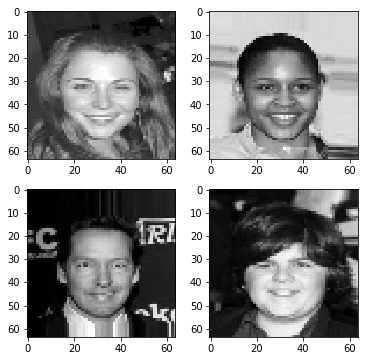

In [12]:
plt.figure(figsize=(6,6))
for n,image in enumerate(celeb_image_ds.take(4)):
    plt.subplot(2,2,n+1)
    image = tf.reshape(image, image.shape[:2])
    plt.imshow(image, cmap=plt.cm.gray)
    plt.grid(False)


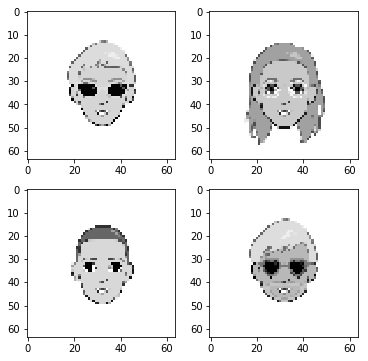

In [13]:
plt.figure(figsize=(6,6))
for n,image in enumerate(cartoon_image_ds.take(4)):
    plt.subplot(2,2,n+1)
    image = tf.reshape(image, image.shape[:2])
    plt.imshow(image, cmap=plt.cm.gray)
    plt.grid(False)


In [14]:
def conv(img, f):
    x = f.shape[0]
    y = img.shape[0]
    ci = np.zeros((y-x+1,y-x+1))
    #print(ci)
    for i in range(y-x+1):
        for j in range(y-x+1):
            ci[i,j] = np.sum(f * img[i:i+x,j:j+x])
    return ci

conv(np.array([[1,2,3],[1,2,3],[1,2,3]]), np.array([[1,2],[1,2]]))

array([[10., 16.],
       [10., 16.]])

In [15]:
'''from skimage import feature
from scipy import ndimage as ndi

for img in image_ds.take(4):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 4),
                                    sharex=True, sharey=True)
    
    im2 = tf.image.resize_images(img, [50, 50])
    im2 = tf.image.rgb_to_grayscale(im2)
    im2 = tf.reshape(im2, im2.shape[:2])
    ax1.imshow(im2, cmap=plt.cm.gray)
    
    
    im1 = ndi.gaussian_filter(img, 3)
    im1 = tf.image.resize_images(im1, [50, 50])
    im1 = tf.image.rgb_to_grayscale(im1)
    im1 = tf.reshape(im1, im1.shape[:2])
    
    ax2.imshow(im1, cmap=plt.cm.gray)
    
    fil = np.array([
        [0.5,4,0.5],
        [4,20,4],
        [0.5,4,0.5]
    ])
    fil = fil/np.sum(fil)
    
    #ci = conv(img, fil)
    #ax3.imshow(ci, cmap=plt.cm.gray)
    
    im1 = ndi.gaussian_filter(img, 4)
    im1 = tf.image.resize_images(im1, [50, 50])
    im1 = tf.image.rgb_to_grayscale(im1)
    im1 = tf.reshape(im1, im1.shape[:2])
    
    ax3.imshow(im1, cmap=plt.cm.gray)
    
    fig.tight_layout()
    plt.show()
    '''

'from skimage import feature\nfrom scipy import ndimage as ndi\n\nfor img in image_ds.take(4):\n    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 4),\n                                    sharex=True, sharey=True)\n    \n    im2 = tf.image.resize_images(img, [50, 50])\n    im2 = tf.image.rgb_to_grayscale(im2)\n    im2 = tf.reshape(im2, im2.shape[:2])\n    ax1.imshow(im2, cmap=plt.cm.gray)\n    \n    \n    im1 = ndi.gaussian_filter(img, 3)\n    im1 = tf.image.resize_images(im1, [50, 50])\n    im1 = tf.image.rgb_to_grayscale(im1)\n    im1 = tf.reshape(im1, im1.shape[:2])\n    \n    ax2.imshow(im1, cmap=plt.cm.gray)\n    \n    fil = np.array([\n        [0.5,4,0.5],\n        [4,20,4],\n        [0.5,4,0.5]\n    ])\n    fil = fil/np.sum(fil)\n    \n    #ci = conv(img, fil)\n    #ax3.imshow(ci, cmap=plt.cm.gray)\n    \n    im1 = ndi.gaussian_filter(img, 4)\n    im1 = tf.image.resize_images(im1, [50, 50])\n    im1 = tf.image.rgb_to_grayscale(im1)\n    im1 = tf.reshape(im1, 

In [16]:
fil = np.array([
        [1,2,1],
        [2,4,2],
        [1,2,1]
    ])
fil = fil/np.sum(fil)
fil = tf.reshape(fil, [1,3,3,1])
tf.cast(fil, tf.float32)

<tf.Tensor: id=114, shape=(1, 3, 3, 1), dtype=float32, numpy=
array([[[[0.0625],
         [0.125 ],
         [0.0625]],

        [[0.125 ],
         [0.25  ],
         [0.125 ]],

        [[0.0625],
         [0.125 ],
         [0.0625]]]], dtype=float32)>

In [17]:
celeb_BATCH_SIZE = 64
celeb_ds = celeb_image_ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=len(celeb_small_path)))
celeb_ds = celeb_ds.batch(celeb_BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
celeb_ds = celeb_ds.prefetch(buffer_size=AUTOTUNE)
celeb_ds

<DatasetV1Adapter shapes: (?, 64, 64, 1), types: tf.float32>

In [18]:
cartoon_BATCH_SIZE = 64
cartoon_ds = cartoon_image_ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=len(cartoon_image_path)))
cartoon_ds = cartoon_ds.batch(cartoon_BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
cartoon_ds = cartoon_ds.prefetch(buffer_size=AUTOTUNE)
cartoon_ds

<DatasetV1Adapter shapes: (?, 64, 64, 1), types: tf.float32>

In [19]:
"""i = 0
start = time.time()
for cartoon in cartoon_ds:
    print(time.time()-start)
    start = time.time()
    print(cartoon.shape)
    i = i + 1
    if i==3:
        break
"""

'i = 0\nstart = time.time()\nfor cartoon in cartoon_ds:\n    print(time.time()-start)\n    start = time.time()\n    print(cartoon.shape)\n    i = i + 1\n    if i==3:\n        break\n'

In [20]:
for cartoon in cartoon_ds:
    test_cartoon = cartoon
    break
for celeb in celeb_ds:
    test_celeb = celeb
    break
    
print(test_cartoon.shape)
print(test_celeb.shape)

(64, 64, 64, 1)
(64, 64, 64, 1)


In [21]:
test_cartoon = test_cartoon[:4]
test_celeb = test_celeb[:4]

In [22]:
def make_generator_model():
    #size down
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(32,(3,3), input_shape = (64,64,1), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(64,(3,3), padding='same'))    
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(64,(5,5), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(64,(5,5), padding='same'))    
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(64,(5,5), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(32,(3,3), padding='same'))    
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(1,(3, 3), padding='same', activation='relu'))

    return model

In [23]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        1

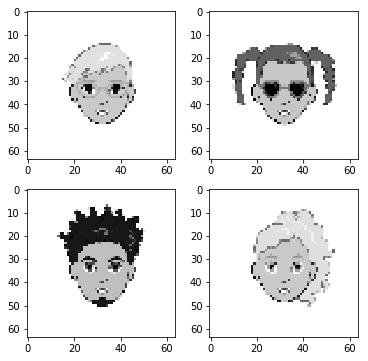

In [24]:
plt.figure(figsize=(6,6))
for n,image in enumerate(test_cartoon):
    plt.subplot(2,2,n+1)
    image = tf.reshape(image, image.shape[:2])
    plt.imshow(image, cmap=plt.cm.gray)
    plt.grid(False)

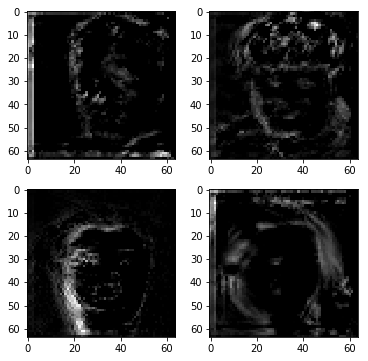

In [25]:
gen_out = generator(test_celeb)
plt.figure(figsize=(6,6))
for n,image in enumerate(gen_out):
    plt.subplot(2,2,n+1)
    image = tf.reshape(image, image.shape[:2])
    plt.imshow(image, cmap=plt.cm.gray)
    plt.grid(False)

In [26]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (7, 7), input_shape=(64,64,1)))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
      
    model.add(tf.keras.layers.Conv2D(64, (5, 5)))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    
    model.add(tf.keras.layers.Conv2D(64, (3, 3)))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    
    model.add(tf.keras.layers.Conv2D(128, (3, 3)))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
       
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64)) 
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
     
    return model

In [27]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 58, 58, 32)        1600      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 58, 58, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 58, 58, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 25, 64)        51264     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 25, 25, 64)       

In [28]:
def generator_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

In [29]:
def discriminator_loss(real_out, generated_out, fake_out):
    real_loss = tf.losses.sigmoid_cross_entropy(tf.ones_like(real_out), real_out)
    generated_loss = tf.losses.sigmoid_cross_entropy(tf.zeros_like(generated_out), generated_out)
    fake_loss = tf.losses.sigmoid_cross_entropy(tf.zeros_like(fake_out), fake_out)
    total_loss = 2 * real_loss + generated_loss + fake_loss
    return total_loss

In [30]:
g_optimizer = tf.train.AdamOptimizer(8e-5)
d_optimizer = tf.train.AdamOptimizer(1e-4)

In [31]:
EPOCHS = 100

In [32]:
def train_step(cartoon_images, celeb_images):
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        
        generated_images = generator(celeb_images, training = True)
        #print(generated_images.shape)
        
        real_out = discriminator(cartoon_images, training =True)
        generated_out = discriminator(generated_images, training = True)
        fake_out = discriminator(celeb_images, training = True)
        
        gen_loss = generator_loss(generated_out)
        dis_loss = discriminator_loss(real_out, generated_out, fake_out)

    
    gen_grad = gen_tape.gradient(gen_loss, generator.variables)
    dis_grad = dis_tape.gradient(dis_loss, discriminator.variables)
    
    #print(gen_grad)
    
    g_optimizer.apply_gradients(zip(gen_grad, generator.variables))
    d_optimizer.apply_gradients(zip(dis_grad, discriminator.variables))
        

In [33]:
train_step = tf.contrib.eager.defun(train_step)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [34]:
def generate_test_prediction(model, epoch):
    # make sure the training parameter is set to False because we
    # don't want to train the batchnorm layer when doing inference.
    
    gen_out = generator(test_celeb)
    plt.figure(figsize=(6,6))
    for n,image in enumerate(gen_out):
        plt.subplot(2,2,n+1)
        image = tf.reshape(image, image.shape[:2])
        plt.imshow(image, cmap=plt.cm.gray)
        plt.grid(False)
    plt.show()
    print(discriminator(gen_out))
    print(discriminator(test_cartoon))
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))

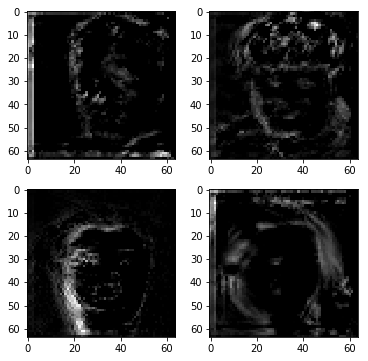

tf.Tensor(
[[0.5000952 ]
 [0.50030303]
 [0.5002736 ]
 [0.5001881 ]], shape=(4, 1), dtype=float32)
tf.Tensor(
[[0.5372051 ]
 [0.53741497]
 [0.5440796 ]
 [0.5364889 ]], shape=(4, 1), dtype=float32)


<Figure size 432x288 with 0 Axes>

In [35]:
generate_test_prediction(generator,1)

In [36]:
def train(epochs):
    epoch = 0
    start = time.time()
    for cartoon_images, celeb_images in zip(cartoon_ds, celeb_ds):
        train_step(cartoon_images, celeb_images)
        epoch = epoch + 1
        if(epoch%5==0):
            display.clear_output(wait = True)
            generate_test_prediction(generator, epoch)
        print ('Time taken for epoch {} is {} sec'.format(epoch, time.time()-start))
        start = time.time()
        if epoch == epochs:
            break

<Figure size 432x288 with 0 Axes>

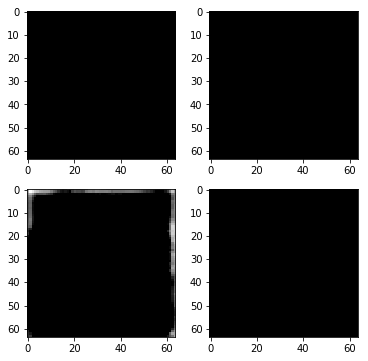

tf.Tensor(
[[0.44662938]
 [0.44662938]
 [0.44663113]
 [0.44662938]], shape=(4, 1), dtype=float32)
tf.Tensor(
[[0.8319214 ]
 [0.841761  ]
 [0.82226145]
 [0.78573596]], shape=(4, 1), dtype=float32)
Time taken for epoch 50 is 24.647582530975342 sec
CPU times: user 39min 26s, sys: 1min 3s, total: 40min 29s
Wall time: 20min 41s


<Figure size 432x288 with 0 Axes>

In [37]:
%%time
train(50)

In [38]:
discriminator(generator(test_celeb))

<tf.Tensor: id=4624, shape=(4, 1), dtype=float32, numpy=
array([[0.44662938],
       [0.44662938],
       [0.44663113],
       [0.44662938]], dtype=float32)>

In [39]:
discriminator(test_cartoon)

<tf.Tensor: id=4659, shape=(4, 1), dtype=float32, numpy=
array([[0.8319214 ],
       [0.841761  ],
       [0.82226145],
       [0.78573596]], dtype=float32)>